1) Read in all files
2) See how many 0's, 1's
3) Analyze file (see the average length) 

In [9]:
import os
import pathlib

data_path = os.path.join(os.getcwd(),"data")
print(data_path)
for dirName, subdirList, fileList in os.walk(data_path):
    zeros = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '0']
    ones = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '1']
print(f"Zeros: {len(zeros)}\nOnes: {len(ones)}")

import pandas as pd

all_files = zeros + ones
file_lengths = []
for f in all_files:
    df = pd.read_csv(os.path.join(data_path,f))
    file_lengths.append(df.shape[0])
pd.Series(file_lengths).describe()

c:\Users\m.litton_local\ca_disengagement\ca_disengagement\data
Zeros: 44
Ones: 55


count     99.000000
mean     425.272727
std      107.123409
min      239.000000
25%      334.000000
50%      443.000000
75%      463.000000
max      858.000000
dtype: float64

4) For each file, take 5 seconds before and 1 second after the event of interest (sampling every 0.5 seconds)

In [10]:
sample_interval = 0.5
seconds_before = 5
seconds_after = 1

all_seqs = []
for file in all_files:
    df = pd.read_csv(os.path.join(data_path,file),index_col=0)

    #The "event of interest" is:
    #   For '1' paths, when the minimum distance is (this will be during the lane change)
    #   For '0' paths, when the minimum distance once the adversary gets in front of the ego is
    if file in zeros:
        in_front = df[df['angle'].abs() < 5]
        if(in_front.shape[0]>0):
            min_dist = in_front['distance'].min()
            min_dist_idx = in_front['distance'].idxmin()
        else:
            print(f"the file: ({file}) is in zeros but no time in front")
    if file in ones:
        min_dist = df['distance'].min()
        min_dist_idx = df['distance'].idxmin()
    
    start_idx = min_dist_idx - seconds_before * (2*sample_interval/0.05)
    stop_idx = min_dist_idx + seconds_after * (2*sample_interval/0.05)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/0.05)): indices_to_sample.append(x)

    columns_of_interest = ['distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    try:
        rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    except:
        print(f"bad keys in file {file}")
        print(indices_to_sample)
        continue
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(file.split(".csv")[0].split("_",2)[2])
    all_seqs.append(one_seq)

full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * 13 + ['class']))
full_df.to_csv(os.path.join(os.getcwd(),"classifier_data\\labeled_data.csv"),index=None)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Columns: 261 entries, distance to class
dtypes: float64(260), object(1)
memory usage: 202.0+ KB


5) Generate Train/Test Files

In [11]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv(os.path.join(os.getcwd(),"classifier_data\\train_file.csv"),index=None)
test.to_csv(os.path.join(os.getcwd(),"classifier_data\\test_file.csv"),index=None)


In [12]:
x_train.head()

,distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z,adv_vel_x,adv_vel_y,adv_vel_z,adv_accel_x,adv_accel_y,adv_accel_z,adv_ang_vel_x,adv_ang_vel_y,adv_ang_vel_z
29,2.415499,-46.501185,2.093448,-0.003759,-0.000802,-0.989499,0.043124,-0.006516,-0.090764,-0.379585,...,0.932387,3.833628,-0.039128,0.065516,-0.783825,2.240886,-0.016985,0.380308,-0.164359,-3.872994
4,2.420711,-43.131539,2.075471,-0.004015,-0.000266,0.329924,0.035283,0.009093,-0.007856,0.088742,...,-0.854216,3.720380,-0.155289,0.063130,-0.730100,-0.027741,-0.007600,0.149874,-0.141786,-9.168257
44,0.397835,-134.891516,2.225805,-0.004670,0.000872,0.813313,0.036838,0.002084,0.030798,0.325388,...,9.558273,2.374212,0.391204,0.016609,-0.339894,0.305241,0.008626,-0.139566,-0.238989,3.524171
81,1.394040,-107.069218,2.196823,-0.004539,0.007363,-0.560832,0.043227,-0.013034,-0.057841,-0.277965,...,6.884645,2.420340,0.430309,0.035263,0.814829,0.476266,-0.029961,3.187637,-0.036557,5.136649
62,1.404443,-73.888908,2.219574,-0.006835,0.032812,1.133041,-0.042110,0.022266,0.109421,0.307318,...,2.926132,2.388953,0.442135,0.056791,-1.859446,-2.653977,-0.001104,2.515415,0.211529,5.944141


In [13]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

1.0

[(51, 'adv_vel_x', 0.06), (241, 'angle', 0.05), (211, 'adv_vel_x', 0.04), (180, 'distance', 0.04), (20, 'distance', 0.04), (161, 'angle', 0.04), (1, 'angle', 0.033093750000000005), (160, 'distance', 0.03230769230769231), (212, 'adv_vel_y', 0.03), (100, 'distance', 0.03), (231, 'adv_vel_x', 0.03), (21, 'angle', 0.03), (152, 'adv_vel_y', 0.03), (81, 'angle', 0.03), (221, 'angle', 0.03), (11, 'adv_vel_x', 0.03), (111, 'adv_vel_x', 0.03), (181, 'angle', 0.03), (172, 'adv_vel_y', 0.02), (120, 'distance', 0.02)]
81.92307692307692


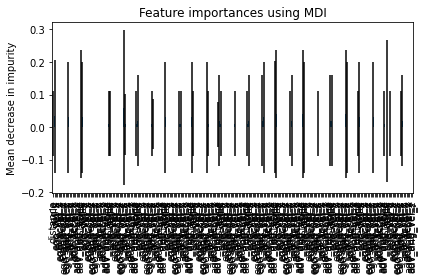

In [14]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1]
sorted_tuple = [(i,feature_names[i],importances[i]) for i in sorted_importances]
print(sorted_tuple[:20])
print(len([x for x in sorted_tuple if x[2]==0])/len(sorted_tuple) * 100)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


